In [191]:
#### import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
from random import randrange

# seed 13
np.random.seed(15)
random.seed(5)

In [192]:
def add_features(df):
    df['month'] = df['PRICES'].dt.month - 1
    df['day'] = df['PRICES'].dt.day - 1
    df['year'] = df['PRICES'].dt.year
    df['day_of_week'] = df['PRICES'].dt.dayofweek
    df['day_of_week'] = df['day_of_week'].astype(int)
    return df

train = pd.read_excel("train.xlsx", parse_dates=['PRICES'])
val = pd.read_excel("validate.xlsx", parse_dates=['PRICES'])
train = add_features(train)
val = add_features(val)
train.head()

,PRICES,Hour 01,Hour 02,Hour 03,Hour 04,Hour 05,Hour 06,Hour 07,Hour 08,Hour 09,...,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24,month,day,year,day_of_week
0,2007-01-01,24.31,24.31,21.71,8.42,0.01,0.01,0.02,0.01,0.01,...,37.99,33.11,37.99,33.00,36.48,30.65,0,0,2007,0
1,2007-01-02,16.01,11.00,9.01,7.50,9.00,7.45,16.50,28.01,29.96,...,59.69,50.09,50.00,36.22,31.09,29.84,0,1,2007,1
2,2007-01-03,28.00,24.50,24.15,18.99,15.50,23.11,29.01,39.73,43.81,...,60.99,55.51,51.77,34.51,39.31,38.05,0,2,2007,2
3,2007-01-04,31.01,28.69,27.00,24.20,12.02,27.00,28.00,34.85,41.31,...,58.99,53.50,44.01,35.00,34.46,31.57,0,3,2007,3
4,2007-01-05,22.00,19.50,17.55,15.91,11.40,22.65,27.30,34.00,40.01,...,53.00,45.91,36.74,29.61,30.61,27.51,0,4,2007,4


## Environment

In [193]:
import gym
import numpy as np
import pandas as pd

class Electric_Car(gym.Env):
    def __init__(self, path_to_test_data=str):
        # Define a continuous action space, -1 to 1. (You can discretize this later!)
        self.continuous_action_space = gym.spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        # Define the test data
        self.test_data = pd.read_excel(path_to_test_data)
        self.price_values = self.test_data.iloc[:, 1:25].to_numpy()
        self.timestamps = self.test_data['PRICES']
        self.state = np.empty(7)

        # Battery characteristics
        self.battery_capacity = 50  # kWh
        self.max_power = 25 / 0.9  # kW
        self.charge_efficiency = 0.9  # -
        self.discharge_efficiency = 0.9  # -
        self.battery_level = self.battery_capacity / 2  # kWh (start at 50%)
        self.minimum_morning_level = 20  # kWh
        self.car_use_consumption = 20  # kWh

        # Time Tracking
        self.counter = 0
        self.hour = 1
        self.day = 1
        self.car_is_available = True

    def step(self, action):

        action = np.squeeze(action)  # Remove the extra dimension

        if action <-1 or action >1:
            raise ValueError('Action must be between -1 and 1')

        # Calculate if, at 7am and after the chosen action, the battery level will be below the minimum morning level:
        if self.hour == 8:
            if action > 0 and (self.battery_level < self.minimum_morning_level):
                if (
                        self.battery_level + action * self.max_power * self.charge_efficiency) < self.minimum_morning_level:  # If the chosen action will not charge the battery to 20kWh
                    action = (self.minimum_morning_level - self.battery_level) / (
                                self.max_power * self.charge_efficiency)  # Charge until 20kWh
            elif action < 0:
                if (self.battery_level + action * self.max_power) < self.minimum_morning_level:
                    if self.battery_level < self.minimum_morning_level:  # If the level was lower than 20kWh, charge until 20kWh
                        action = (self.minimum_morning_level - self.battery_level) / (
                                    self.max_power * self.charge_efficiency)  # Charge until 20kWh
                    elif self.battery_level >= self.minimum_morning_level:  # If the level was higher than 20kWh, discharge until 20kWh
                        action = (self.minimum_morning_level - self.battery_level) / (
                            self.max_power)  # Discharge until 20kWh
            elif action == 0:
                if self.battery_level < self.minimum_morning_level:
                    action = (self.minimum_morning_level - self.battery_level) / (
                                self.max_power * self.charge_efficiency)

        if not self.car_is_available:
            action = 0

        # Calculate the costs and battery level when charging (action >0)
        if (action > 0) and (self.battery_level <= self.battery_capacity):
            if (self.battery_level + action * self.max_power * self.charge_efficiency) > self.battery_capacity:
                action = (self.battery_capacity - self.battery_level) / (self.max_power * self.charge_efficiency)
            charged_electricity_kW = action * self.max_power
            charged_electricity_costs = charged_electricity_kW * self.price_values[self.day - 1][
                self.hour-1] * 2 * 1e-3
            reward = -charged_electricity_costs
            self.battery_level += charged_electricity_kW * self.charge_efficiency
        # Calculate the profits and battery level when discharging (action <0)
        elif (action < 0) and (self.battery_level >= 0):
            if (self.battery_level + action * self.max_power) < 0:
                action = -self.battery_level / (self.max_power)
            discharged_electricity_kWh = action * self.max_power  # Negative discharge value
            discharged_electricity_profits = abs(discharged_electricity_kWh) * self.discharge_efficiency * \
                                             self.price_values[self.day - 1][self.hour-1] * 1e-3
            reward = discharged_electricity_profits
            self.battery_level += discharged_electricity_kWh
            # Some small numerical errors causing the battery level to be 1e-14 to 1e-17 under 0 :
            if self.battery_level < 0:
                self.battery_level = 0

        else:
            reward = 0

        self.counter += 1  # Increase the counter
        self.hour += 1  # Increase the hour

        # There is a 50% chance that the car is unavailable from 8am to 6pm
        if self.hour == 9:
            self.car_is_available = np.random.choice([True, False])
            if not self.car_is_available:
                self.battery_level -= self.car_use_consumption
        if self.hour == 19:
            self.car_is_available = True

        if self.counter % 24 == 0:  # If the counter is a multiple of 24, increase the day, reset hour to first hour
            self.day += 1
            self.hour = 1

        terminated = self.counter == len(
            self.price_values.flatten()) - 1  # If the counter is equal to the number of hours in the test data, terminate the episode
        truncated = False

        info = action  # The final action taken after all constraints! For debugging purposes

        self.state = self.observation()  # Update the state

        return self.state, reward, terminated, truncated, info

    def observation(self):  # Returns the current state
        battery_level = self.battery_level
        price = self.price_values[self.day - 1][self.hour-1]
        hour = self.hour
        day_of_week = self.timestamps[self.day - 1].dayofweek  # Monday = 0, Sunday = 6
        day_of_year = self.timestamps[self.day - 1].dayofyear  # January 1st = 1, December 31st = 365
        month = self.timestamps[self.day - 1].month  # January = 1, December = 12
        year = self.timestamps[self.day - 1].year
        self.state = np.array(
            [battery_level, price, int(hour), int(day_of_week), int(day_of_year), int(month), int(year),
             int(self.car_is_available)])

        return self.state

In [195]:
class CustomDiscreteActionSpace(spaces.Discrete):
    def __init__(self, start=-25, end=25, step=12.5):
        num_actions = int((end - start) / step) + 1
        super(CustomDiscreteActionSpace, self).__init__(num_actions)
        self.start = start
        self.step_size = step
        self.end = end
    def map_to_action(self, action_index):
        return self.start + action_index * self.step_size

custom_action_space = CustomDiscreteActionSpace()

class QAgent():
    def __init__(self, env, action_space=custom_action_space, discount_rate = 0.95, learning_rate=0.3, epsilon=0.5):
        self.env = env
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.price_bins = np.array([-1,20,27,32,37,43,50,60,72,88,3000]) 
        self.action_space = action_space
        self.state_space = [5, len(self.price_bins)-1, 24, self.action_space.n]
        self.Qtable = np.zeros(self.state_space)
        self.profit = []
        self.time_constraint = 8
        self.all_profits = []
        self.max_power = 25

    def mask(self):
        # 7 am constraint  
        if self.env.hour == self.time_constraint and self.env.battery_level >= self.env.minimum_morning_level:
            lower_bound = min(np.ceil((self.env.minimum_morning_level - self.env.battery_level)*0.9), self.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity - self.env.battery_level)/0.9), self.max_power)
            mask_range = (lower_bound, upper_bound)
        elif self.env.hour == self.time_constraint and self.env.battery_level < self.env.minimum_morning_level:
            lower_bound = min(np.ceil((self.env.minimum_morning_level - self.env.battery_level)/0.9), self.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity - self.env.battery_level)/0.9), self.max_power)
            mask_range = (lower_bound, upper_bound)
        else: 
            lower_bound = max(np.ceil(-(self.env.battery_level)*0.9), -self.max_power)
            upper_bound = min(np.floor((self.env.battery_capacity - self.env.battery_level)/0.9), self.max_power)
            mask_range = (lower_bound, upper_bound)
                
        # construct boolean mask_vector
        mask = np.arange(self.action_space.start, self.action_space.end + 1, self.action_space.step_size) 
        mask = np.where((mask >= mask_range[0]) & (mask <= mask_range[1]), True, False)
        return mask

    def reward_shape(self, reward, continuous_action):
        if continuous_action < 0:
            reward -= 0.05 * 25
        return reward

    def to_continuous(self, action):
        continuous = np.linspace(-1 , 1, 5)
        return continuous[action]

    def discretize_features(self, features):
        battery, price, hour  = features[0], features[1], features[2]
        return tuple([int(battery//10.001), np.max(np.where(self.price_bins<price)), int(hour - 1)])

    def reset(self):
        # Battery characteristics
        self.env.battery_level = self.env.battery_capacity / 2  # kWh (start at 50%)

        # Time Tracking
        self.env.counter = 0
        self.env.hour = 1
        self.env.day = 1
        self.env.car_is_available = True
        
    def select_action_epsilon_greedy(self, current_state):
        mask = self.mask()

        #pick random action
        if (np.random.uniform(0,1) > 1-self.epsilon) or (np.all(self.Qtable[current_state] == 0)):
            
            action = np.random.choice(np.arange(self.action_space.n)[mask])
        #pick greedy action
        else:
            max_action = np.argmax(self.Qtable[current_state][mask])
            action = np.where(mask)[0][0] + max_action
        return action

    def train(self, simulations = 100, epsilon = 0.1):
        for i in range(simulations):
            done = False
            profits = 0
            self.epsilon = max(0.05, self.epsilon - 0.05)
            self.learning_rate *= 0.9
            while not done:    
                current_state = self.env.observation()
                current_state = self.discretize_features(current_state) 
                action = self.select_action_epsilon_greedy(current_state)
                continuous_action = self.to_continuous(action)
                
                next_state, reward, done, truncated, info = self.env.step(continuous_action)
                profits += reward
                
                next_state = self.discretize_features(next_state)
                next_state_mask = self.mask()
                reward = self.reward_shape(reward, continuous_action)
                
                # update Q_values
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state][next_state_mask]))
                delta = self.learning_rate * (Q_target - self.Qtable[current_state][action])
                self.Qtable[current_state][action] = self.Qtable[current_state][action] + delta

            print(f'{i} simulations done')
            self.all_profits.append(profits)
            self.reset()
            
    def predict(self, state):
        mask = self.mask()
        max_action = np.argmax(self.Qtable[state][mask])
        action = np.where(mask)[0][0] + max_action
        return action


    def plot_profits(self):
        plt.plot(self.all_profits)
        plt.xlabel('Epochs')
        plt.ylabel('Profit')
        plt.title("Cost per epoch")

## Train

0 simulations done
1 simulations done
2 simulations done
3 simulations done
4 simulations done
5 simulations done
6 simulations done
7 simulations done
8 simulations done
9 simulations done
10 simulations done
11 simulations done
12 simulations done
13 simulations done
14 simulations done
15 simulations done


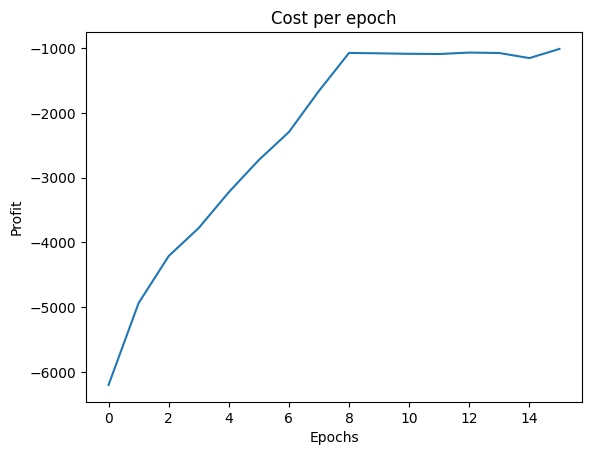

In [196]:
env = Electric_Car(path_to_test_data='train.xlsx')
agent = QAgent(env, action_space=custom_action_space)
agent.train(simulations=16)
agent.plot_profits()

## Eval

In [197]:
eval_env = Electric_Car(path_to_test_data='validate.xlsx')
agent.env = eval_env
discrete_act = [-25, -12.5, 0, 12.5, 25]
done = False
profits = 0

while not done:
    current_state = agent.env.observation()
    battery, price, hour  = current_state[0], current_state[1], current_state[2]
    current_state = agent.discretize_features(current_state)
    
    action = agent.predict(current_state)
    continuous_action = agent.to_continuous(action)
    if agent.env.car_is_available:
        print(f"at time {hour} agent transacts {discrete_act[action]}, price is {price} battery is {battery}")
    next_state, reward, done, trucated, info = agent.env.step(continuous_action)
    profits += reward


print("Profit on validation set: ", profits)

at time 1.0 agent transacts 0, price is 13.2 battery is 25.0
at time 2.0 agent transacts 0, price is 13.14 battery is 25.0
at time 3.0 agent transacts 0, price is 11.83 battery is 25.0
at time 4.0 agent transacts 0, price is 9.49 battery is 25.0
at time 5.0 agent transacts 0, price is 8.63 battery is 25.0
at time 6.0 agent transacts 0, price is 7.12 battery is 25.0
at time 7.0 agent transacts 0, price is 4.06 battery is 25.0
at time 8.0 agent transacts 0, price is 1.0 battery is 25.0
at time 9.0 agent transacts 0, price is 8.4 battery is 25.0
at time 10.0 agent transacts 0, price is 9.11 battery is 25.0
at time 11.0 agent transacts 0, price is 10.18 battery is 25.0
at time 12.0 agent transacts 0, price is 13.56 battery is 25.0
at time 13.0 agent transacts 25, price is 18.02 battery is 25.0
at time 14.0 agent transacts 0, price is 15.02 battery is 50.0
at time 15.0 agent transacts 0, price is 12.58 battery is 50.0
at time 16.0 agent transacts 0, price is 10.18 battery is 50.0
at time 17